In [33]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import label, regionprops
import random
import glob
import os
from sklearn.cluster import KMeans
from PIL import Image as im
from sklearn.mixture import GaussianMixture

# Set seed for K-means clustering reproducibility
random.seed(10)

In [34]:
def remove_large_background(array,window_size,step_size,max_mean):
    '''
    Scans across an image and removes large pixel blobs i.e. blocks where almost all pixels are filled in.
    Parameters:
    array: input 2d array of pixels
    window_size: size of box used when calculating proportion of filled pixels.  Should be larger than desired cell width.
    step_size: movement distance between one window and the next
    max_mean: mean that pixels in a window must reach for them to be removed.
    '''
    clean_array=np.copy(array)
    for i in range(0,len(array)-window_size,step_size):
        for j in range(0,len(array[i])-window_size,step_size):    
            subset=array[i:i+window_size,j:j+window_size]
            if subset.mean()>max_mean:
                clean_array[max(i-step_size,0):min(i+window_size+step_size,len(array)-1),max(j-window_size,0):min(j+window_size+step_size,len(array[i]))]=0 #replace pixels of region passing max_mean threshold with 0
    return clean_array

def make_custom_grayscale(red_channel,blue_channel):
    '''
    Convert red and blue channels to a single grayscale array by taking the max at each coordinate.
    Parameters:
    red_channel: 2d np array of red pixel values
    blue_channel: 2d np array of blue pixel values
    '''
    custom_gray=[]
    for i,row in enumerate(red_channel):
        custom_gray.append([])
        for j,col in enumerate(row):
            if red_channel[i,j]>blue_channel[i,j]:
                custom_gray[-1].append(red_channel[i,j]*255)
            else:
                custom_gray[-1].append(blue_channel[i,j]*255)
    custom_gray=np.array(custom_gray).astype(np.uint8)
    return custom_gray

In [35]:
# K-means approach as a function
def GMM_process_image(image_path):
    # 1. Read image and convert to RGB
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Split into RGB channels for thresholding
    red_channel = image_rgb[:, :, 0]
    blue_channel = image_rgb[:, :, 2]
    
    # 2. Define thresholds for red and blue channels based on percentiles
    #     # try: r-92,b-95
    # red_threshold = np.percentile(red_channel, 85)
    # blue_threshold = np.percentile(blue_channel, 95)
    
    #     # Create binary masks for each color channel
    #         # CHANGED from red/blue_threshold
    # _, red_mask = cv2.threshold(red_channel, red_threshold, 255, cv2.THRESH_BINARY)
    # _, blue_mask = cv2.threshold(blue_channel, blue_threshold, 255, cv2.THRESH_BINARY)
    #     # Combine the red and blue masks
    # combined_mask = cv2.bitwise_or(red_mask, blue_mask)

    #---------------------NEW
    # Normalize red and blue channels
    red_normalized = red_channel / (np.max(red_channel) + 1e-6)
    blue_normalized = blue_channel / (np.max(blue_channel) + 1e-6)
    
    # Define combined mask based on adaptive thresholds
    red_threshold = np.percentile(red_normalized, 98)
    blue_threshold = np.percentile(blue_normalized, 98)
    
    _, red_mask = cv2.threshold((red_normalized * 255).astype(np.uint8), red_threshold * 255, 255, cv2.THRESH_BINARY)
    _, blue_mask = cv2.threshold((blue_normalized * 255).astype(np.uint8), blue_threshold * 255, 255, cv2.THRESH_BINARY)
    
    # Combine the masks
    combined_mask = cv2.bitwise_or(red_mask, blue_mask)
    #---------------------
        # Apply the mask to isolate high-intensity pixels in the image
    thresholded_image = cv2.bitwise_and(image_rgb, image_rgb, mask=combined_mask)

    # 3. Perform K-means clustering
        # Flatten the masked pixels (ignore dark background)
    masked_pixels = thresholded_image[combined_mask > 0]
    pixels = masked_pixels.reshape((-1, 3)).astype(np.float32)
        # Define K-means criteria and number of clusters
    k = 4  # Number of clusters
    # criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    #     # Perform K-means clustering--cv2
    # # _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    #     # preform K-means clustering--scikit
    # kmeans = KMeans(n_clusters=k, n_init=10, random_state=42).fit(pixels)
    #     # Convert centers to uint8 for display
    # centers = np.uint8(kmeans.cluster_centers_)
    #     # Reconstruct segmented data using labels
    # labels = kmeans.labels_
    # segmented_data = centers[labels.flatten()]

    #---------------------NEW
    # Perform GMM clustering
    gmm = GaussianMixture(n_components=k, random_state=42).fit(pixels)
    labels = gmm.predict(pixels)
    
    # Convert cluster centers to uint8 for reconstruction
    centers = np.uint8(gmm.means_)
    segmented_data = centers[labels]
    #---------------------
    
    # Create an empty array to store the full-sized segmented image
    segmented_image = np.zeros_like(image_rgb)
        # Fill in only the high-intensity pixels in the original mask
    segmented_image[combined_mask > 0] = segmented_data


    # 4. Subset mask by keeping only the clusters corresponding to red and blue
        # Automate cluster characterization based on RBG values
            # instantiate cluster values
    bg_cluster = -1
    red_cluster = -1
    blue_cluster = -1
    lab_cluster = -1
        # instantiate list of color values outside loop
    max_g_val = -1
    max_r_val = -1
    max_b_val = -1
        # 4.1: Identify labels cluster
            # iterate over centers (RGB values)
    for idx, cntr in enumerate(centers):
        print(idx, cntr)
            # set green value
        g_val = cntr[1]
            # compare to max green value
        if g_val > max_g_val:
                # update max green value
            max_g_val = g_val
                # set max green value to background cluster
            lab_cluster = idx
        # identify red cluster
    for idx, cntr in enumerate(centers):
            # exclude cluster previously identified as bg
        if idx != lab_cluster:
            # set red value
            r_val = cntr[0]
            # compare to max red value
            if r_val > max_r_val:
                max_r_val = r_val
                red_cluster = idx
        # 4.3: Identify BLUE cluster
    for idx, cntr in enumerate(centers):
            # exclude clusters previously identified as bg & red
        if idx != lab_cluster and idx != red_cluster:
            # set red value
            b_val = cntr[2]
            # compare to max red value
            if b_val > max_b_val:
                max_b_val = b_val
                blue_cluster = idx
        # 4.2: Identify bg cluster
    for idx, cntr in enumerate(centers):
            # exclude cluster previously identified as bg
        if idx != lab_cluster and idx != red_cluster and idx != blue_cluster:
            bg_cluster = idx
    print("Background cluster is", bg_cluster)
    print("Labeled cluster is", lab_cluster)
    print("Red cluster is", red_cluster)
    print("Blue cluster is", blue_cluster)
        # Reshape labels to match combined_mask shape
    labels_reshaped = np.zeros(combined_mask.shape, dtype=int)
    labels_reshaped[combined_mask > 0] = labels.flatten()
        # Create a mask that includes only the red and blue clusters
    foreground_mask = np.isin(labels_reshaped, [red_cluster, blue_cluster])
    bg_mask = np.isin(labels_reshaped, [bg_cluster, lab_cluster])
        # Initialize the foreground image with black background
    foreground_final = np.zeros_like(image_rgb)
    bground_final = np.zeros_like(image_rgb)
        # Apply the mask to keep only the red and blue clusters
    foreground_final[foreground_mask] = image_rgb[foreground_mask]
    bground_final[bg_mask] = image_rgb[bg_mask]

    # 5. Perform Canny edge detection on the final foreground
        # foreground_final or custom_gray
    edges = cv2.Canny(foreground_final, 100, 200, apertureSize=3, L2gradient=False)

    # 6. Find contours and filter by area
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Set minimum & maximum cell area threshold
    min_area = 500
    max_area = 20000
    
    # Set aspect ratio thresholds (adjust based on cell shapes in your images)
    min_aspect_ratio = 2.0  # Minimum ratio for pencil-shaped cells
    max_aspect_ratio = 40.0  # Maximum ratio for pencil-shaped cells
    
    cell_contours = []
    # for cnt in contours:
    #     area = cv2.contourArea(cnt)
    #     if min_area < area < max_area:
    #         # Calculate bounding rectangle and aspect ratio
    #         x, y, w, h = cv2.boundingRect(cnt)
    #         aspect_ratio = max(w, h) / min(w, h)  # Ensure the ratio is always >= 1
    #         # print(w,h,aspect_ratio)
    #         # Filter by aspect ratio
    #         if min_aspect_ratio <= aspect_ratio <= max_aspect_ratio:
    #             cell_contours.append(cnt)
    #---------------------NEW
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if min_area < area < max_area:
            # Get rotated bounding box
            rect = cv2.minAreaRect(cnt)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            # Calculate width and height of the rotated rectangle
            width = rect[1][0]
            height = rect[1][1]
            # Ensure width is the smaller dimension
            short_side, long_side = sorted([width, height])
            # Calculate aspect ratio
            aspect_ratio = long_side / short_side
            print(aspect_ratio, long_side, short_side, area)
            # Filter by aspect ratio
            if min_aspect_ratio <= aspect_ratio <= max_aspect_ratio:
                cell_contours.append(cnt)
    #---------------------

        # Initialize metrics for counting and blue:red ratio
    total_cells = len(cell_contours)
    cell_ratios = []
        # Create a copy of the original image for cell-labeling
    labeled_image = foreground_final.copy()
        # Count all filtered edges (cells) & calculate blue:red ratio
    print(f"Total cells detected: {total_cells}")

    # 7. Calculate blue:red ratios within each cell
    for i, contour in enumerate(cell_contours):
        # Create a mask for each cell
        cell_mask = np.zeros(foreground_mask.shape, dtype=np.uint8)
        cv2.drawContours(cell_mask, [contour], -1, 255, -1)  # Fill contour to create mask
        # Extract pixels in red and blue channels for this cell
        red_values = red_channel[cell_mask == 255]
        blue_values = blue_channel[cell_mask == 255]
        # Calculate blue:red ratio for this cell
        red_sum = np.sum(red_values)
        blue_sum = np.sum(blue_values)
        blue_red_ratio = blue_sum / red_sum if red_sum > 0 else 0  # Avoid division by zero
        proportion_infected = blue_sum / (blue_sum + red_sum) if (blue_sum + red_sum) > 0 else 0
        cell_ratios.append({
            'Cell Number': i + 1,
            'Red Intensity Sum': red_sum,
            'Blue Intensity Sum': blue_sum,
            'Blue:Red Ratio': blue_red_ratio,
            'Proportion Infected': proportion_infected
        })
            # Label the detected cell on the image
        M = cv2.moments(contour)  # Get moments of the contour to calculate centroid
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])  # Centroid X
            cY = int(M["m01"] / M["m00"])  # Centroid Y
            cv2.putText(
                labeled_image, 
                str(i + 1),  # Label with cell number
                (cX, cY),  # Position at centroid
                cv2.FONT_HERSHEY_SIMPLEX, 
                3,  # Font size
                (255, 255, 255),  # White text
                2  # Thickness
            )

    # add edges to labeled image
    cv2.drawContours(labeled_image, cell_contours, -1, (0, 255, 0), 2)  # Green contours with thickness 2

    # 8. Convert ratios to DataFrame for easy viewing
    cell_ratios_df = pd.DataFrame(cell_ratios)
        # Calculate & report image overall blue:red ratio
    total_red = np.sum(red_channel[foreground_mask])
    total_blue = np.sum(blue_channel[foreground_mask])
    overall_blue_red_ratio = total_blue / total_red if total_red > 0 else 0
        # Display results
    print("\nIndividual Cell Blue:Red Ratios")
    # print(cell_ratios_df)
    print(f"\nTotal Cells: {total_cells}")
    print(f"Overall Blue:Red Ratio in Image: {overall_blue_red_ratio:.2f}")
    # Convert labeled_image (numpy array) to a Pillow image
    labeled_image_pil = im.fromarray(labeled_image)
 
        # Display the final cell edges
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(image_rgb)
    plt.title('Original RGB')
    plt.subplot(1, 4, 2)
    plt.imshow(bground_final, cmap='gray') #edges, bground_final
    plt.title('BG mask') # Canny Edge Detection
    plt.subplot(1, 4, 3)
    plt.imshow(labeled_image)
    plt.title('Foreground with Detected Cells')
    plt.subplot(1, 4, 4)
    plt.imshow(labeled_image_pil)
    plt.title('Returned Image')
    plt.show()
    # print(type(cell_ratios_df))
    # print(type(labeled_image))
    return cell_ratios_df, labeled_image_pil



Processing THN_STARTER_1-20240716.jpg
0 [97  0 81]
1 [ 28   0 171]
2 [ 26   0 243]
3 [218 211 230]
Background cluster is 1
Labeled cluster is 3
Red cluster is 0
Blue cluster is 2
22.428571428571427 157.0 7.0 1091.5
1.9506172255186196 47.16476058959961 24.17940330505371 542.0
1.1176470588235294 57.0 51.0 826.5
2.2287046900622074 49.03888702392578 22.003313064575195 674.0
1.4291402781360731 82.29193878173828 57.58142852783203 3082.5
1.105263157894737 37.58264923095703 34.00334930419922 938.0
1.5789473974670376 43.656410217285156 27.649059295654297 790.0
Total cells detected: 2

Individual Cell Blue:Red Ratios

Total Cells: 2
Overall Blue:Red Ratio in Image: 2.53


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_68202/2763557850.py:171: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


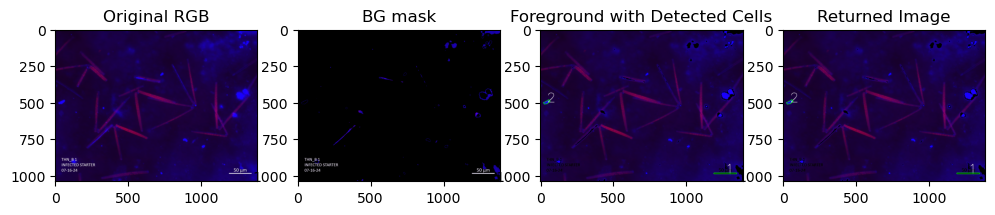

Saved results to ../../figures/GMM_classification/data/THN_STARTER_1-20240716.csv
Saved labeled image to ../../figures/GMM_classification/classified/THN_STARTER_1-20240716_labeled.jpg

Processing THN_A_I_15_1-20240724.jpg
0 [81  0 79]
1 [211 201 218]
2 [ 41   0 194]
3 [104   1 137]
Background cluster is 0
Labeled cluster is 1
Red cluster is 3
Blue cluster is 2
5.388508821050367 97.0008773803711 18.001432418823242 955.5
1.236842105263158 47.0 38.0 1327.0
2.6195220719293864 66.67314910888672 25.452409744262695 503.0
Total cells detected: 2

Individual Cell Blue:Red Ratios

Total Cells: 2
Overall Blue:Red Ratio in Image: 2.50


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_68202/2763557850.py:171: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


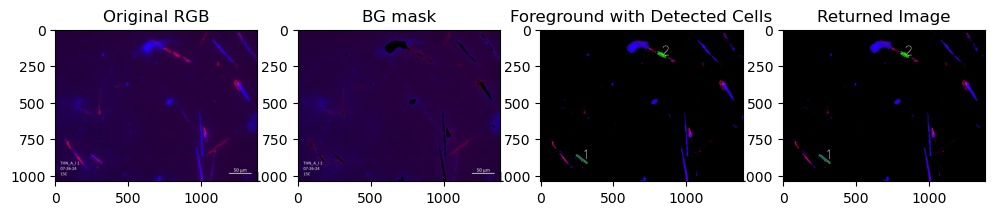

Saved results to ../../figures/GMM_classification/data/THN_A_I_15_1-20240724.csv
Saved labeled image to ../../figures/GMM_classification/classified/THN_A_I_15_1-20240724_labeled.jpg

Processing AS_C_U_15_3-20240717.jpg
0 [76  0 38]
1 [214 209 218]
2 [ 13   0 119]
3 [ 13   1 134]
Background cluster is 2
Labeled cluster is 1
Red cluster is 0
Blue cluster is 3
22.285714285714285 156.0 7.0 1085.5
Total cells detected: 1

Individual Cell Blue:Red Ratios

Total Cells: 1
Overall Blue:Red Ratio in Image: 2.45


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_68202/2763557850.py:171: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


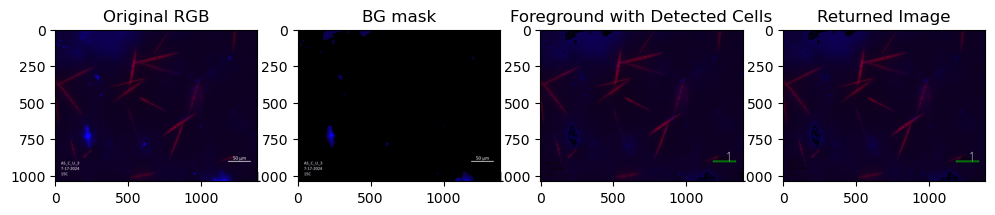

Saved results to ../../figures/GMM_classification/data/AS_C_U_15_3-20240717.csv
Saved labeled image to ../../figures/GMM_classification/classified/AS_C_U_15_3-20240717_labeled.jpg

Processing AS_A_I_22_4-20240718.jpg
0 [ 27   0 136]
1 [207 199 207]
2 [74  1 29]
3 [ 46   0 177]
Background cluster is 0
Labeled cluster is 1
Red cluster is 2
Blue cluster is 3
10.71180138034995 137.27133178710938 12.814962387084961 1310.5
1.127574371542446 70.89193725585938 62.871185302734375 3178.5
Total cells detected: 1

Individual Cell Blue:Red Ratios

Total Cells: 1
Overall Blue:Red Ratio in Image: 1.29


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_68202/2763557850.py:171: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


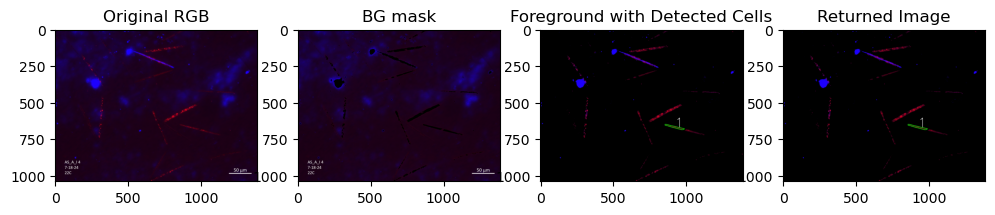

Saved results to ../../figures/GMM_classification/data/AS_A_I_22_4-20240718.csv
Saved labeled image to ../../figures/GMM_classification/classified/AS_A_I_22_4-20240718_labeled.jpg

Processing AS_B_I_22_5-20240720.jpg
0 [23  0 96]
1 [134   1  47]
2 [ 36   0 191]
3 [213 207 216]
Background cluster is 0
Labeled cluster is 3
Red cluster is 1
Blue cluster is 2
12.052054199700748 220.9710235595703 18.334718704223633 2876.5
1.5263158958023577 38.90758514404297 25.491174697875977 734.0
26.15603112206155 263.1869812011719 10.062191009521484 1618.0
12.799999046754317 204.89207458496094 16.00719451904297 2386.0
11.097864345785789 284.6458435058594 25.648704528808594 3679.5
10.926218413146861 218.22439575195312 19.972545623779297 3047.0
8.850801529235033 191.44659423828125 21.63042449951172 2705.5
Total cells detected: 6

Individual Cell Blue:Red Ratios

Total Cells: 6
Overall Blue:Red Ratio in Image: 0.92


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_68202/2763557850.py:171: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


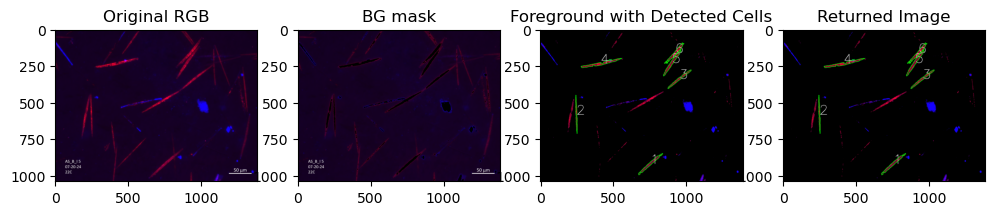

Saved results to ../../figures/GMM_classification/data/AS_B_I_22_5-20240720.csv
Saved labeled image to ../../figures/GMM_classification/classified/AS_B_I_22_5-20240720_labeled.jpg

Processing AS_B_U_15_1-20240726.jpg
0 [ 12   0 198]
1 [126   1  58]
2 [ 29   0 214]
3 [218 214 222]
Background cluster is 0
Labeled cluster is 3
Red cluster is 1
Blue cluster is 2
6.819443998710172 136.17889404296875 19.969207763671875 1694.5
6.333333418127307 94.97431945800781 14.99594497680664 1017.5
3.333092316798106 123.19964599609375 36.96256637573242 3294.5
6.137885623866686 147.8023223876953 24.080331802368164 1592.0
9.925737399869586 178.55471801757812 17.989063262939453 2161.0
2.1013215976297888 72.2706527709961 34.39295196533203 1536.0
Total cells detected: 6

Individual Cell Blue:Red Ratios

Total Cells: 6
Overall Blue:Red Ratio in Image: 0.94


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_68202/2763557850.py:171: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


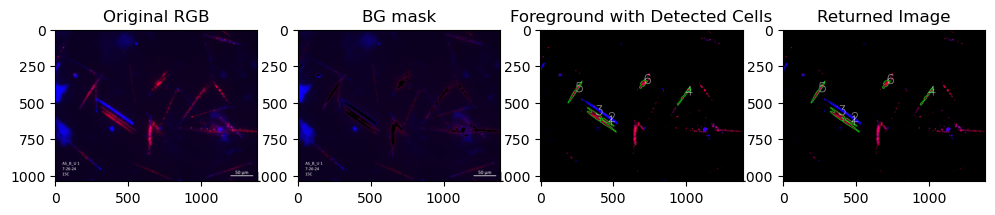

Saved results to ../../figures/GMM_classification/data/AS_B_U_15_1-20240726.csv
Saved labeled image to ../../figures/GMM_classification/classified/AS_B_U_15_1-20240726_labeled.jpg

Processing AS_B_I_22_6-20240717.jpg
0 [ 31   0 103]
1 [248 243 249]
2 [61  0 31]
3 [158  25  59]
Background cluster is 2
Labeled cluster is 1
Red cluster is 3
Blue cluster is 0
22.428571428571427 157.0 7.0 1097.0
7.943423121807127 119.46234130859375 15.039151191711426 920.5
5.758619964459638 74.68466186523438 12.969194412231445 664.5
2.6547618767410714 49.47925567626953 18.63792610168457 595.5
Total cells detected: 4

Individual Cell Blue:Red Ratios

Total Cells: 4
Overall Blue:Red Ratio in Image: 1.05


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_68202/2763557850.py:171: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


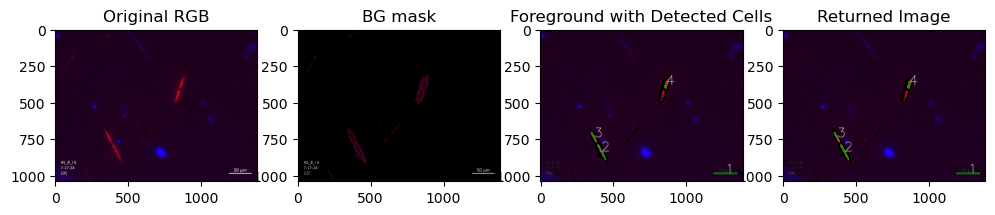

Saved results to ../../figures/GMM_classification/data/AS_B_I_22_6-20240717.csv
Saved labeled image to ../../figures/GMM_classification/classified/AS_B_I_22_6-20240717_labeled.jpg

Processing THN_C_I_22_2-20240720.jpg
0 [54  0 39]
1 [203 199 210]
2 [ 21   0 120]
3 [12  0 63]
Background cluster is 3
Labeled cluster is 1
Red cluster is 0
Blue cluster is 2
22.428571428571427 157.0 7.0 1093.0
1.4782608695652173 34.0 23.0 523.5
1.0357142857142858 29.0 28.0 600.0
1.0174029558098674 58.289337158203125 57.29228210449219 2487.0
Total cells detected: 1

Individual Cell Blue:Red Ratios

Total Cells: 1
Overall Blue:Red Ratio in Image: 3.03


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_68202/2763557850.py:171: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


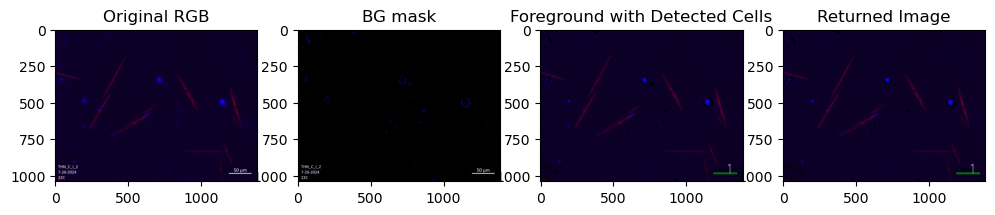

Saved results to ../../figures/GMM_classification/data/THN_C_I_22_2-20240720.csv
Saved labeled image to ../../figures/GMM_classification/classified/THN_C_I_22_2-20240720_labeled.jpg

Processing THN_A_I_22_3-20240724.jpg
0 [74  0 28]
1 [209 201 209]
2 [ 42   0 112]
3 [27  0 65]
Background cluster is 3
Labeled cluster is 1
Red cluster is 0
Blue cluster is 2
1.1115591957311346 61.42802429199219 55.262935638427734 2579.0
1.6356201238226211 70.25142669677734 42.95094299316406 1912.5
1.0 31.0 31.0 654.5
Total cells detected: 0

Individual Cell Blue:Red Ratios

Total Cells: 0
Overall Blue:Red Ratio in Image: 1.03


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_68202/2763557850.py:171: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


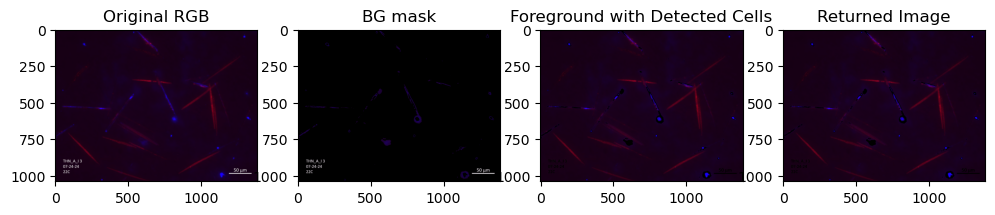

Saved results to ../../figures/GMM_classification/data/THN_A_I_22_3-20240724.csv
Saved labeled image to ../../figures/GMM_classification/classified/THN_A_I_22_3-20240724_labeled.jpg

Processing AS_A_I_22_5-20240718.jpg
0 [102  68 147]
1 [50  0 29]
2 [ 30   0 107]
3 [254 251 254]
Background cluster is 1
Labeled cluster is 3
Red cluster is 0
Blue cluster is 2
22.428571428571427 157.0 7.0 1097.0
7.8683905062746335 138.0842742919922 17.549240112304688 1553.5
10.59453813507028 142.04225158691406 13.407120704650879 1336.0
10.743591518163175 132.4994354248047 12.332880973815918 1002.0
8.752474802521434 106.22882080078125 12.137003898620605 793.5
7.261904652745348 84.59178161621094 11.648704528808594 651.0
Total cells detected: 6

Individual Cell Blue:Red Ratios

Total Cells: 6
Overall Blue:Red Ratio in Image: 1.08


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_68202/2763557850.py:171: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


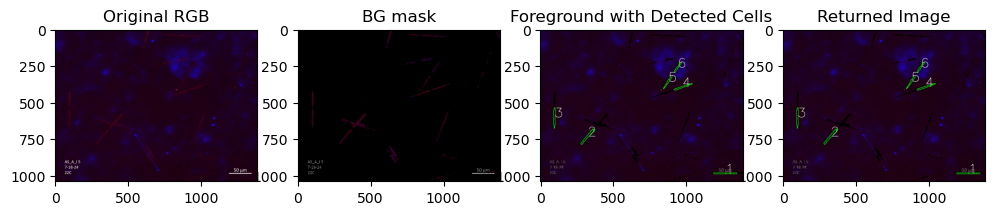

Saved results to ../../figures/GMM_classification/data/AS_A_I_22_5-20240718.csv
Saved labeled image to ../../figures/GMM_classification/classified/AS_A_I_22_5-20240718_labeled.jpg

Processing THN_A_I_22_1-20240717.jpg
0 [42  0 77]
1 [254 251 254]
2 [126   1  34]
3 [182 163 174]
Background cluster is 2
Labeled cluster is 1
Red cluster is 3
Blue cluster is 0
4.76666617296967 69.36518096923828 14.55213737487793 542.5
6.470552863889578 116.66062927246094 18.029468536376953 1529.0
8.751855494898823 122.18958282470703 13.961563110351562 890.0
10.333334941751149 98.03060913085938 9.486831665039062 538.5
Total cells detected: 4

Individual Cell Blue:Red Ratios

Total Cells: 4
Overall Blue:Red Ratio in Image: 0.64


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_68202/2763557850.py:171: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


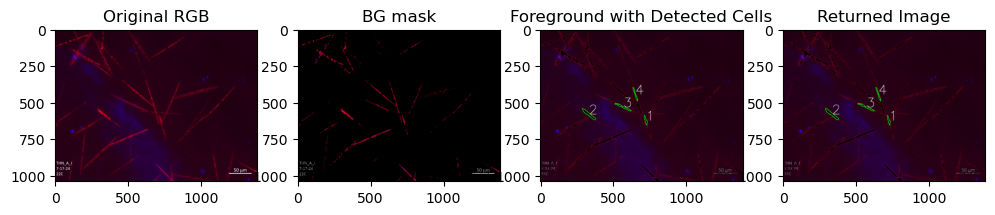

Saved results to ../../figures/GMM_classification/data/THN_A_I_22_1-20240717.csv
Saved labeled image to ../../figures/GMM_classification/classified/THN_A_I_22_1-20240717_labeled.jpg

Processing AS_Starter_3-20240711.jpg
0 [54  1 29]
1 [  2   0 253]
2 [  3   0 189]
3 [207 206 213]
Background cluster is 2
Labeled cluster is 3
Red cluster is 0
Blue cluster is 1
1.121212121212121 37.0 33.0 1023.5
1.1785714285714286 33.0 28.0 716.0
1.7556037950759458 89.5886001586914 51.03007888793945 3665.5
2.276901324567625 75.48590087890625 33.15290832519531 1578.5
1.2619339123226043 55.188167572021484 43.733009338378906 1610.0
1.4132873458850155 55.69366455078125 39.40717697143555 1243.0
Total cells detected: 1

Individual Cell Blue:Red Ratios

Total Cells: 1
Overall Blue:Red Ratio in Image: 5.90


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_68202/2763557850.py:171: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


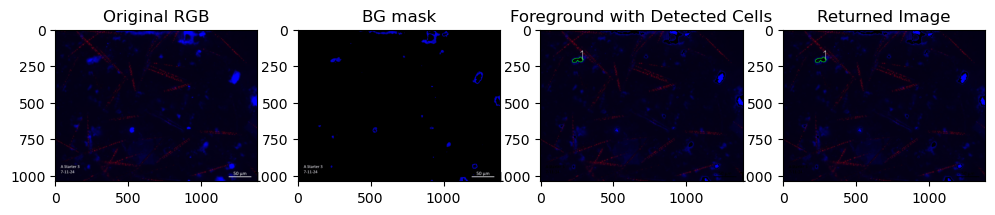

Saved results to ../../figures/GMM_classification/data/AS_Starter_3-20240711.csv
Saved labeled image to ../../figures/GMM_classification/classified/AS_Starter_3-20240711_labeled.jpg

Processing AS_STARTER_2-20240716.jpg
0 [70  3 60]
1 [210 203 217]
2 [ 35   1 135]
3 [ 40   0 104]
Background cluster is 3
Labeled cluster is 1
Red cluster is 0
Blue cluster is 2
22.428571428571427 157.0 7.0 1092.0
Total cells detected: 1

Individual Cell Blue:Red Ratios

Total Cells: 1
Overall Blue:Red Ratio in Image: 2.22


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_68202/2763557850.py:171: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


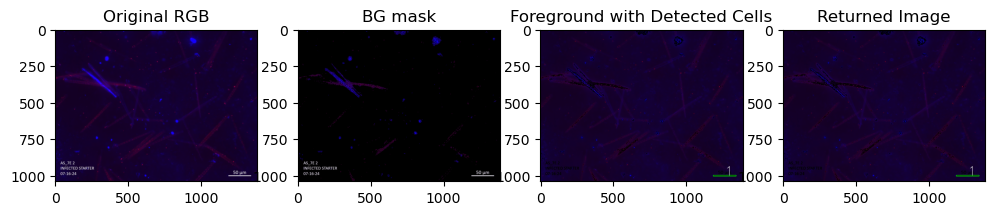

Saved results to ../../figures/GMM_classification/data/AS_STARTER_2-20240716.csv
Saved labeled image to ../../figures/GMM_classification/classified/AS_STARTER_2-20240716_labeled.jpg

Processing AS_STARTER_5-20240716.jpg
0 [ 18   0 142]
1 [213 207 224]
2 [74  1 65]
3 [ 21   1 155]
Background cluster is 0
Labeled cluster is 1
Red cluster is 2
Blue cluster is 3
19.232666360104922 191.21783447265625 9.942346572875977 1265.0
6.784172588007558 88.22335815429688 13.004291534423828 639.0
Total cells detected: 2

Individual Cell Blue:Red Ratios

Total Cells: 2
Overall Blue:Red Ratio in Image: 1.35


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_68202/2763557850.py:171: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


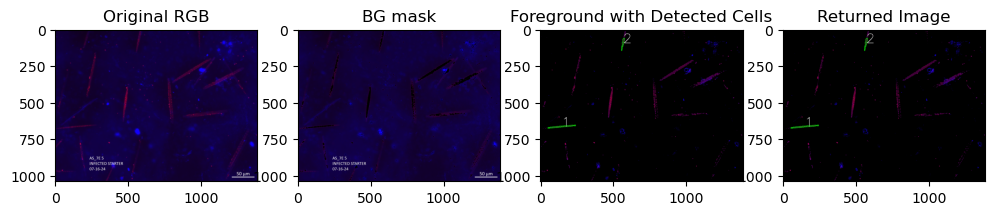

Saved results to ../../figures/GMM_classification/data/AS_STARTER_5-20240716.csv
Saved labeled image to ../../figures/GMM_classification/classified/AS_STARTER_5-20240716_labeled.jpg

Processing AS_Starter_1-20240711.jpg
0 [58  1 29]
1 [  3   0 253]
2 [252 252 254]
3 [100  81 168]
Background cluster is 0
Labeled cluster is 2
Red cluster is 3
Blue cluster is 1
Total cells detected: 0

Individual Cell Blue:Red Ratios

Total Cells: 0
Overall Blue:Red Ratio in Image: 21.71


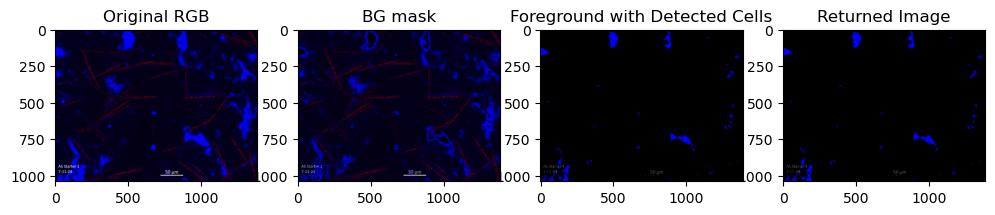

Saved results to ../../figures/GMM_classification/data/AS_Starter_1-20240711.csv
Saved labeled image to ../../figures/GMM_classification/classified/AS_Starter_1-20240711_labeled.jpg

Processing THN_C_I_15_3-20240724.jpg
0 [114   1  42]
1 [217 213 221]
2 [63  0 91]
3 [ 45   1 140]
Background cluster is 2
Labeled cluster is 1
Red cluster is 0
Blue cluster is 3
Total cells detected: 0

Individual Cell Blue:Red Ratios

Total Cells: 0
Overall Blue:Red Ratio in Image: 1.76


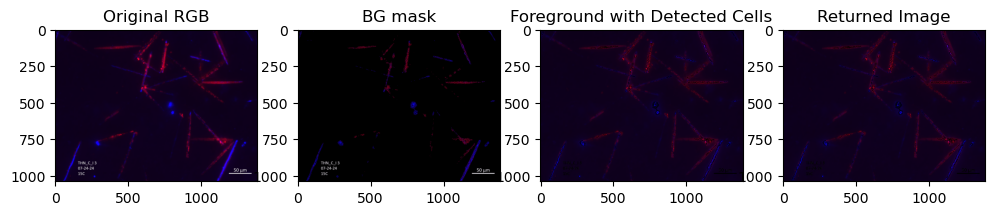

Saved results to ../../figures/GMM_classification/data/THN_C_I_15_3-20240724.csv
Saved labeled image to ../../figures/GMM_classification/classified/THN_C_I_15_3-20240724_labeled.jpg

Processing AS_A_I_15_4-20240720.jpg
0 [ 27   0 244]
1 [ 88   0 145]
2 [64  0 47]
3 [210 202 214]
Background cluster is 2
Labeled cluster is 3
Red cluster is 1
Blue cluster is 0
22.428571428571427 157.0 7.0 1092.5
3.6746576593062215 104.21896362304688 28.361543655395508 1246.5
Total cells detected: 2

Individual Cell Blue:Red Ratios

Total Cells: 2
Overall Blue:Red Ratio in Image: 2.41


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_68202/2763557850.py:171: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


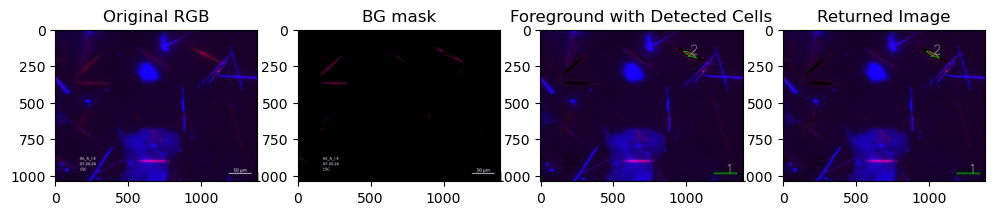

Saved results to ../../figures/GMM_classification/data/AS_A_I_15_4-20240720.csv
Saved labeled image to ../../figures/GMM_classification/classified/AS_A_I_15_4-20240720_labeled.jpg

Processing THN_A_I_15_1-20240717.jpg
0 [  7   0 243]
1 [87  0 56]
2 [253 252 254]
3 [171 168 193]
Background cluster is 1
Labeled cluster is 2
Red cluster is 3
Blue cluster is 0
22.428571428571427 157.0 7.0 1097.0
9.315789574279313 116.20620727539062 12.474112510681152 995.5
16.01250250671406 310.6881408691406 19.402847290039062 4094.5
6.972899586447072 117.31869506835938 16.824951171875 1421.5
10.30275105180217 104.82160186767578 10.174137115478516 671.0
11.493150346074852 122.73828887939453 10.679255485534668 805.5
10.306121532519747 96.74044799804688 9.386697769165039 545.0
15.114014065346874 278.7680969238281 18.444345474243164 3770.0
Total cells detected: 8

Individual Cell Blue:Red Ratios

Total Cells: 8
Overall Blue:Red Ratio in Image: 6.62


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_68202/2763557850.py:171: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


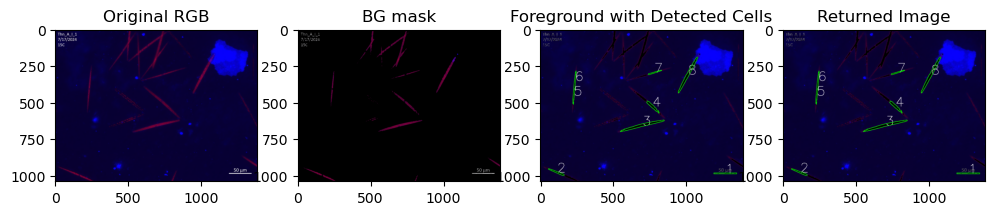

Saved results to ../../figures/GMM_classification/data/THN_A_I_15_1-20240717.csv
Saved labeled image to ../../figures/GMM_classification/classified/THN_A_I_15_1-20240717_labeled.jpg

Processing AS_C_I_15_2-20240726.jpg
0 [60  0 55]
1 [ 16   0 190]
2 [ 90   1 111]
3 [206 201 212]
Background cluster is 0
Labeled cluster is 3
Red cluster is 2
Blue cluster is 1
1.9358060298569866 45.10820388793945 23.302026748657227 537.5
1.3814434310237802 42.37451934814453 30.674089431762695 1023.0
1.093862970582139 32.86497116088867 30.044870376586914 764.5
13.379024143215105 279.3677673339844 20.881027221679688 2875.0
Total cells detected: 1

Individual Cell Blue:Red Ratios

Total Cells: 1
Overall Blue:Red Ratio in Image: 3.78


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_68202/2763557850.py:171: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


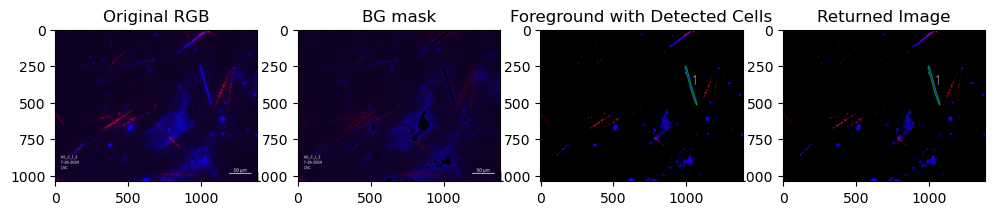

Saved results to ../../figures/GMM_classification/data/AS_C_I_15_2-20240726.csv
Saved labeled image to ../../figures/GMM_classification/classified/AS_C_I_15_2-20240726_labeled.jpg

Processing THN_STARTER_4-20240716.jpg
0 [ 25   0 185]
1 [223 218 227]
2 [107   1 138]
3 [118   0  88]
Background cluster is 2
Labeled cluster is 1
Red cluster is 3
Blue cluster is 0
1.2164227348558023 51.479705810546875 42.32057189941406 840.5
Total cells detected: 0

Individual Cell Blue:Red Ratios

Total Cells: 0
Overall Blue:Red Ratio in Image: 2.14


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_68202/2763557850.py:171: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


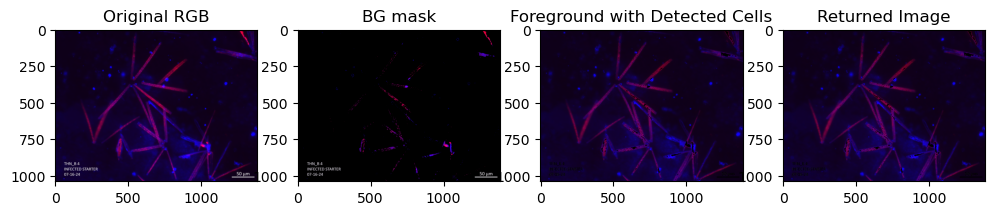

Saved results to ../../figures/GMM_classification/data/THN_STARTER_4-20240716.csv
Saved labeled image to ../../figures/GMM_classification/classified/THN_STARTER_4-20240716_labeled.jpg

Processing AS_B_I_15_4-20240724.jpg
0 [ 52   0 253]
1 [224 219 229]
2 [81  0 74]
3 [ 23   0 183]
Background cluster is 3
Labeled cluster is 1
Red cluster is 2
Blue cluster is 0
31.4 157.0 5.0 781.5
13.513227507227915 113.6515121459961 8.41038990020752 586.0
9.665706214872214 170.79710388183594 17.670421600341797 1740.0
19.244898498020653 166.82974243164062 8.668777465820312 894.0
Total cells detected: 4

Individual Cell Blue:Red Ratios

Total Cells: 4
Overall Blue:Red Ratio in Image: 2.29


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_68202/2763557850.py:171: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


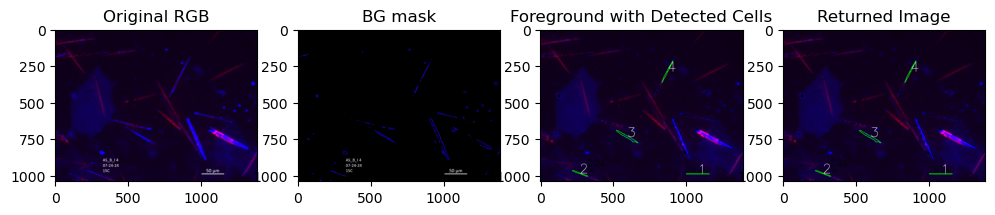

Saved results to ../../figures/GMM_classification/data/AS_B_I_15_4-20240724.csv
Saved labeled image to ../../figures/GMM_classification/classified/AS_B_I_15_4-20240724_labeled.jpg

Processing THN_Starter_5-20240711.jpg
0 [49  0 30]
1 [202 200 207]
2 [ 22   1 123]
3 [  3   0 161]
Background cluster is 2
Labeled cluster is 1
Red cluster is 0
Blue cluster is 3
Total cells detected: 0

Individual Cell Blue:Red Ratios

Total Cells: 0
Overall Blue:Red Ratio in Image: 6.22


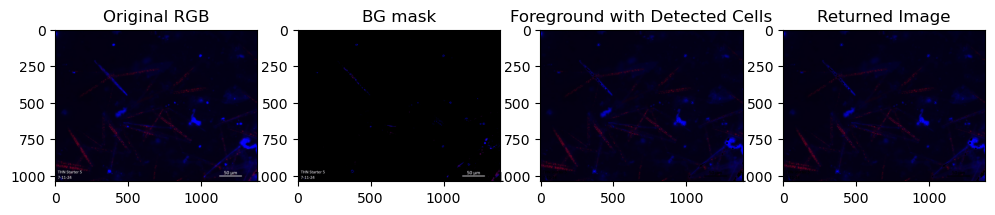

Saved results to ../../figures/GMM_classification/data/THN_Starter_5-20240711.csv
Saved labeled image to ../../figures/GMM_classification/classified/THN_Starter_5-20240711_labeled.jpg

Processing THN_Starter_2-20240711.jpg
0 [  3   0 121]
1 [28  0 25]
2 [16  0 84]
3 [199 198 203]
Background cluster is 2
Labeled cluster is 3
Red cluster is 1
Blue cluster is 0
Total cells detected: 0

Individual Cell Blue:Red Ratios

Total Cells: 0
Overall Blue:Red Ratio in Image: 6.38


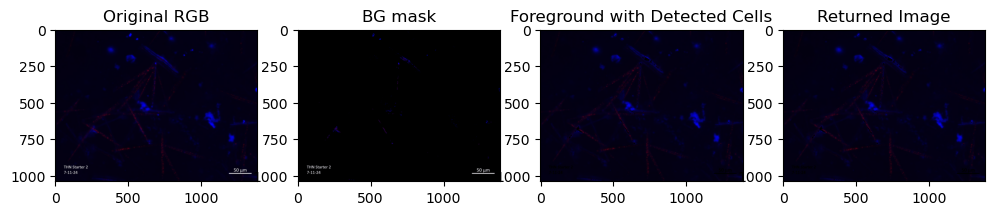

Saved results to ../../figures/GMM_classification/data/THN_Starter_2-20240711.csv
Saved labeled image to ../../figures/GMM_classification/classified/THN_Starter_2-20240711_labeled.jpg

Processing AS_C_I_15_3-20240724.jpg
0 [202  26 129]
1 [245 241 249]
2 [ 35   0 207]
3 [102   0  59]
Background cluster is 3
Labeled cluster is 1
Red cluster is 0
Blue cluster is 2
7.137931062832172 82.80000305175781 11.600000381469727 628.5
5.853018500775527 114.850830078125 19.622495651245117 1632.5
Total cells detected: 2

Individual Cell Blue:Red Ratios

Total Cells: 2
Overall Blue:Red Ratio in Image: 2.22


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_68202/2763557850.py:171: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


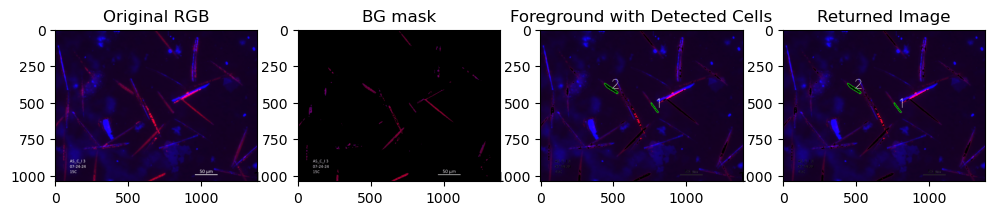

Saved results to ../../figures/GMM_classification/data/AS_C_I_15_3-20240724.csv
Saved labeled image to ../../figures/GMM_classification/classified/AS_C_I_15_3-20240724_labeled.jpg

Processing THN_B_I_15_5-20240726.jpg
0 [158   1 146]
1 [ 30   0 226]
2 [130   0  65]
3 [232 226 235]
Background cluster is 2
Labeled cluster is 3
Red cluster is 0
Blue cluster is 1
31.2 156.0 5.0 777.0
3.880855112791051 90.55220031738281 23.333053588867188 606.0
12.820209450191626 188.59487915039062 14.710748672485352 1608.5
Total cells detected: 3

Individual Cell Blue:Red Ratios

Total Cells: 3
Overall Blue:Red Ratio in Image: 2.05


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_68202/2763557850.py:171: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


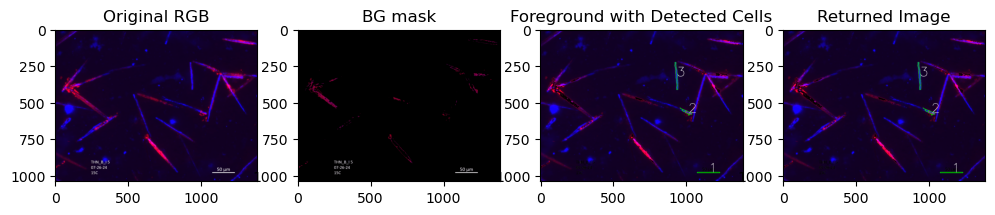

Saved results to ../../figures/GMM_classification/data/THN_B_I_15_5-20240726.csv
Saved labeled image to ../../figures/GMM_classification/classified/THN_B_I_15_5-20240726_labeled.jpg

Processing THN_C_I_15_4-20240720.jpg
0 [ 36   0 235]
1 [177   1  55]
2 [ 36   0 127]
3 [216 209 224]
Background cluster is 2
Labeled cluster is 3
Red cluster is 1
Blue cluster is 0
22.428571428571427 157.0 7.0 1090.0
1.158139465031872 48.832916259765625 42.16497039794922 1230.0
1.0154210285301672 34.46126174926758 33.937904357910156 666.5
8.584396811868835 107.64321899414062 12.539403915405273 645.0
13.580646255693752 140.48475646972656 10.344482421875 928.5
1.0325203156278169 93.6382064819336 90.68897247314453 6551.5
Total cells detected: 3

Individual Cell Blue:Red Ratios

Total Cells: 3
Overall Blue:Red Ratio in Image: 1.13


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_68202/2763557850.py:171: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


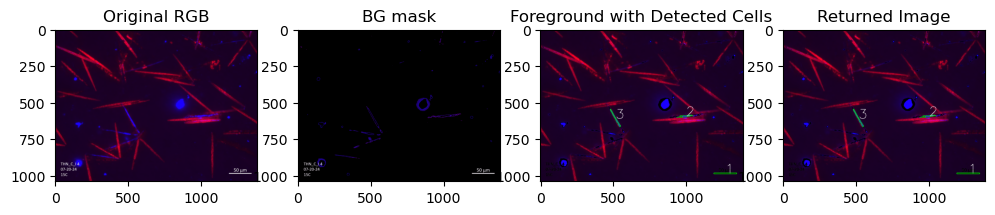

Saved results to ../../figures/GMM_classification/data/THN_C_I_15_4-20240720.csv
Saved labeled image to ../../figures/GMM_classification/classified/THN_C_I_15_4-20240720_labeled.jpg


In [36]:
# Process all images in a folder
image_folder = "../../images/raw/"
image_paths = glob.glob(os.path.join(image_folder, "*.jpg"))
csv_folder = "../../figures/GMM_classification/data/"
jpg_folder = "../../figures/GMM_classification/classified/"

for image_path in image_paths:
    print("")
    print(f"Processing {os.path.basename(image_path)}")
    df, image_output = GMM_process_image(image_path)
    # Generate basename
    base_filename = os.path.splitext(os.path.basename(image_path))[0]
    # Generate .csv output filename based on the input image name
    csv_output_path = os.path.join(csv_folder, f"{base_filename}.csv")
    image_output_path = os.path.join(jpg_folder, f"{base_filename}_labeled.jpg")
    
    # Save the dataframe to a CSV file
    df.to_csv(csv_output_path, index=False)
    # Save the image to a JPG file
    print(f"Saved results to {csv_output_path}")
    # Save the labeled image to a JPG file
    # cv2.imwrite(image_output_path, cv2.cvtColor(image_output, cv2.COLOR_RGB2BGR))  # Convert back to BGR for saving--OLD
    image_output.save(image_output_path)  # Convert back to BGR for saving--NEW
    print(f"Saved labeled image to {image_output_path}")


0 [66  0 32]
1 [188 177 191]
2 [34  0 33]
3 [31  0 79]
Background cluster is 2
Labeled cluster is 1
Red cluster is 0
Blue cluster is 3
Total cells detected: 0

Individual Cell Blue:Red Ratios

Total Cells: 0
Overall Blue:Red Ratio in Image: 1.04


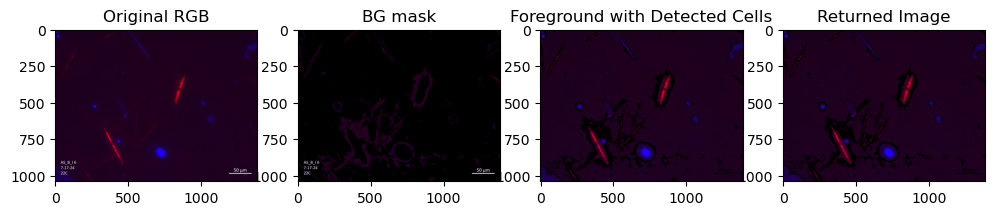

(Empty DataFrame
 Columns: []
 Index: [],
 <PIL.Image.Image image mode=RGB size=1388x1040>)

In [31]:
# img_path = "../../images/raw/AS_A_I_15_4-20240720.jpg"
img_path = "../../images/raw/AS_B_I_22_6-20240717.jpg"
# img_path = "../../images/raw/AS_C_I_15_2-20240726.jpg"
GMM_process_image(img_path)

# # Convert labeled_image (numpy array) to a Pillow image and save as JPEG
# labeled_image_pil = im.fromarray(labeled_image)
# labeled_image_pil.save("labeled_output.jpg")

0 [ 51   0 150]
1 [57  0 69]
2 [243 234 244]
3 [120   2  72]
Background cluster is 1
Labeled cluster is 2
Red cluster is 3
Blue cluster is 0
Total cells detected: 9

Individual Cell Blue:Red Ratios

Total Cells: 9
Overall Blue:Red Ratio in Image: 1.67


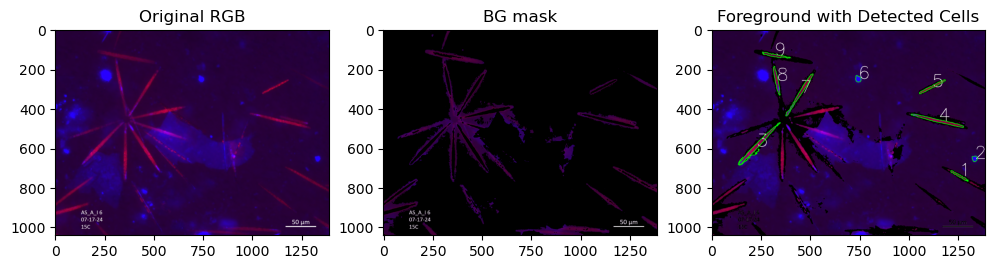

(   Cell Number  Red Intensity Sum  Blue Intensity Sum  Blue:Red Ratio  \
 0            1              95017               51386        0.540808   
 1            2              23231              146917        6.324179   
 2            3             524087              406832        0.776268   
 3            4             417040              246090        0.590087   
 4            5             196079               87974        0.448666   
 5            6              29244              178980        6.120230   
 6            7             334487              234140        0.699997   
 7            8             208639              179183        0.858818   
 8            9             138846               87218        0.628164   
 
    Proportion Infected  
 0             0.350990  
 1             0.863466  
 2             0.437022  
 3             0.371104  
 4             0.309710  
 5             0.859555  
 6             0.411764  
 7             0.462024  
 8             0.385811 

In [60]:
# set image path
# image_path = "../images/manual_classification/raw/AS_A_I_15_4-20240720.jpg"  # WD path
# image_path = "../images/raw/AS_A_I_15_4-20240720.jpg"  # WD path
image_path = "../images/GoodEarlySilica_AS_A_I_15_6_20240717.jpg"  # WD path

# call K-means function
# for image_path in image_paths:
Kmeans_process_image(image_path)

In [14]:
# check blue"red ratios for infection populations
# cell_ratios_df['Blue:Red Ratio'].hist()